# Library Import setting

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
from sklearn.model_selection import train_test_split
import warnings

rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)
warnings.simplefilter('ignore')

In [22]:
# Load the data

data_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\data\astronomical-object')
feature_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\build\feature')
sub_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\build\sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'type'
seed = 42

algo_name = 'rf' #Random Forest
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'
# bagging name. Algo + Feature Combo

feature_file = feature_dir / f'{feature_name}.csv' # 피쳐 파일
sub_file = sub_dir / f'{model_name}' # 해당 모델 이름으로 subission 파일 하나

df = pd.read_csv(feature_file, index_col = 0)
print(df.shape)
df.head()

(210000, 21)


,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,
0,QSO,6.4003,23.1982,21.4320,21.3141,21.1766,21.1714,21.6445,21.6576,21.3877,21.5728,22.5043,21.4316,21.4783,21.1454,20.4224,22.7492,21.4655,21.3642,21.0206,21.1473
1,QSO,6.6708,21.4314,20.7081,20.6789,20.7034,20.4732,21.0298,20.9671,20.9377,21.0636,21.3607,20.7790,20.8897,20.6398,20.6467,21.4930,20.7585,20.7539,20.6934,20.5123
2,QSO,6.0591,17.8515,16.7279,16.6797,16.6946,16.6418,17.0331,16.9997,17.0960,17.0764,17.8673,16.7388,16.6889,16.7442,16.8080,17.8181,16.6974,16.6412,16.6602,16.6889
3,QSO,6.7627,20.7899,20.0404,19.9269,19.8438,19.4633,20.3172,20.2179,20.0739,19.7945,20.4339,19.9937,19.9855,19.7509,19.4551,20.7707,20.0017,19.8898,19.7581,19.5529
4,STAR_RED_DWARF,6.4184,26.4550,23.0588,21.4714,19.5050,18.3891,23.6291,21.7428,19.8617,18.8104,25.8592,22.4269,21.6736,19.6100,18.3761,24.8771,23.1480,21.4753,19.4873,18.3757


In [23]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
y = df[target_col].values[:199991]
df.drop(target_col, axis = 1, inplace = True)
trn = df.iloc[:199991]
tst = df.iloc[199991:]
feature_name = df.columns.tolist() # columns을 리스트로 반환
print(y.shape, trn.shape, tst.shape)

# iloc, loc, [] 차이?

(199991, 22)
(199991,) (199991, 20) (10009, 20)


Q. iloc, loc, [] 차이.
- 일단 모두 데이터를 선택하는 방법. 하지만 사용 방식과 목적이 다름.

- df.iloc[] -> i 인덱스, 정수 위치 기반 인덱싱. 행/열의 번호로 인덱싱함
  e.g) df.iloc[0,1]
- df.loc[] -> 라벨 기반 인덱싱, 행/열 이름으로 인덱싱함. df.loc[0, 'name']
- df[] -> 기본 슬라이싱/ 열 접근. 열 이름 또는 조건. df['name'], df[1:5]

## 학습/ 검증 데이터 구분


In [24]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size = .2, random_state= seed)
#trn과 y를 trn/val로 나눠줌.

print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(159992, 20) (39999, 20) (159992,) (39999,)


In [25]:
# Random Forest Model training

clf = RandomForestClassifier(n_estimators=100,
                             min_samples_leaf=10,
                             max_features='sqrt',
                             max_samples=.5,
                             random_state=seed,
                             n_jobs = -1)

clf.fit(X_trn, y_trn) # 학습 데이터로 학습 후
p_val = clf.predict(X_val) # cv 데이터로 예측 도출
p_tst = clf.predict(tst) # test 셋으로 예측 도출

print(f'{accuracy_score(y_val, p_val)*100:.4f}%')
# cv 스코어 도출. y_val셋과 x_val로 예측한 cv셋

86.6897%


### 피쳐 중요도 시각화 Feature importance visualization

<Axes: ylabel='feature'>

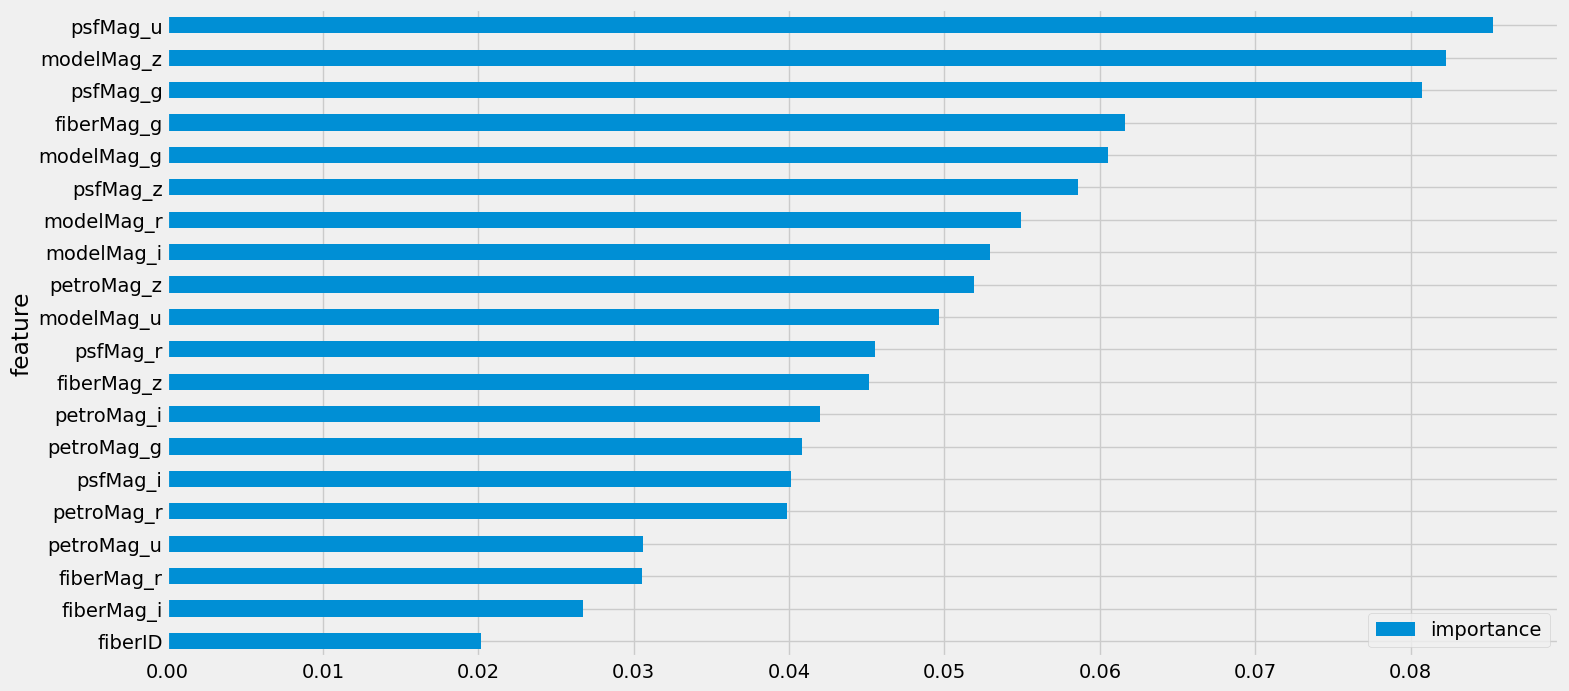

In [26]:
imp = pd.DataFrame({'feature':trn.columns, 'importance':clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [27]:
### submission file

sub = pd.read_csv(sample_file, index_col=0)
# 서브미션 샘플파일을 불러와서, 그 양식에 맞춰 정답을 옮겨적고 제출하는 식이구나.
print(sub.shape)
sub.head()

(10009, 19)


,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# 이 경우에 어떻게 했더라.

pred_prob = clf.predict_proba(tst)
cols = sub.columns.to_list()
sub[cols] = pred_prob
sub.head()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0008,0.0041,0.0,0.0005,0.0000,0.0000,0.0000,0.0013,0.1396,0.0,0.0,0.0,0.0018,0.0000,0.0000,0.0,0.8519,0.0,0.0
199992,0.0061,0.4391,0.0,0.2964,0.0025,0.0027,0.2516,0.0000,0.0008,0.0,0.0,0.0,0.0000,0.0008,0.0000,0.0,0.0000,0.0,0.0
199993,0.9934,0.0006,0.0,0.0054,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0006,0.0,0.0000,0.0,0.0
199994,0.0000,0.0880,0.0,0.0189,0.8629,0.0141,0.0161,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0
199995,0.0000,0.0000,0.0,0.0051,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.9949,0.0,0.0


In [31]:
sub.iloc[:5,:].sum(axis=1)

id
199991    1.0
199992    1.0
199993    1.0
199994    1.0
199995    1.0
dtype: float64

In [37]:
sub.to_csv(sub_file, index=True)

In [38]:
df = pd.read_csv(sub_file, index_col = 0)
df.head()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0008,0.0041,0.0,0.0005,0.0000,0.0000,0.0000,0.0013,0.1396,0.0,0.0,0.0,0.0018,0.0000,0.0000,0.0,0.8519,0.0,0.0
199992,0.0061,0.4391,0.0,0.2964,0.0025,0.0027,0.2516,0.0000,0.0008,0.0,0.0,0.0,0.0000,0.0008,0.0000,0.0,0.0000,0.0,0.0
199993,0.9934,0.0006,0.0,0.0054,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0006,0.0,0.0000,0.0,0.0
199994,0.0000,0.0880,0.0,0.0189,0.8629,0.0141,0.0161,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0
199995,0.0000,0.0000,0.0,0.0051,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.9949,0.0,0.0
